In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from  tensorflow import keras 
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(227,227),include_targets=False,num_outputs = 10)
# train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(227,227),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:

import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

loss_fn = brevis.utils.evidence_crossentropy(num_outputs=10)
# model = brevis.BranchModel(name="./models/alexNetv6_evidence_conv2d.hdf5", custom_objects={})
# model = brevis.BranchModel(name="./models/alexNetv6_entropy_conv2d.hdf5", custom_objects={})


model = brevis.BranchModel(name="../models/alexNetv6_logits.hdf5", custom_objects={})           
# model.add_targets(10)
model.add_branches(branches.branch.newBranch_flatten_evidence_noTarget,
                          ["max_pooling2d",
                            "max_pooling2d_1",
                            "dense"
                          ],
                          target_input=False,loop=False,num_outputs=10)
            
model.compile(loss=[trunk_loss,loss_fn,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
# model.summary()

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  max_pooling2d
add Branch to branch point  max_pooling2d_1
add Branch to branch point  dense
KerasTensor(type_spec=TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_2')>]
branch added <brevis.core_v2.BranchModel object at 0x0000027BBEDD97C8>

preset: Other


In [4]:
model.fit(train_ds,validation_ds=validation_ds, epochs = 3,transfer=True)

Freezing Main Layers and setting branch layers training to true
Epoch 1/3
 116/1407 [=>............................] - ETA: 6:27 - loss: 5.5703 - dense_2_loss: 0.2861 - branch_exit_loss: 2.0816 - branch_exit_1_loss: 1.8690 - branch_exit_2_loss: 1.3336 - dense_2_accuracy: 0.9049 - branch_exit_accuracy: 0.3378 - branch_exit_1_accuracy: 0.3793 - branch_exit_2_accuracy: 0.6183

KeyboardInterrupt: 

In [25]:
# SVM reliability diagram with calibration
def classification(y, prob, bins =10):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    linspace = np.linspace(0,1,num=bins)
    fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.')
    pyplot.show()

import math
    
# SVM reliability diagram with calibration
def cumulativeClassification(y, prob, bins =10, thresholdType = ">="):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    print("max",max(prob))
    # linspace = np.linspace(0,math.ceil(max(prob)),num=bins)
    linspace = np.linspace(0,1,num=bins)
    # pyplot.hist(prob,bins=linspace,density=False)
    accuracy = []
    throughputs = []
    for point in linspace:
        true = 0
        false = 0   
        throughput = 0
        for i, p in enumerate(prob):
            
            if threshold == ">=":
                if p >= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
            else:
                if p <= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
        try:
            accuracy.append(true/(true+false))
            throughputs.append(throughput/len(prob))
            # print(point, throughput/len(prob))                
        except:
            accuracy.append(0)
            throughputs.append(0)
            pass
    # print(throughputs)
    pyplot.plot(linspace[:len(throughputs)], throughputs,label="Accepted (y) for threshold (x)")
    fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot calibrated reliability
    # pyplot.plot(mpv, fop, marker='.',label="calibration")
    # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot perfectly calibrated
    # pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    pyplot.plot(linspace[:len(accuracy)], accuracy, marker='.',color='blue',label="Accuracy")
    pyplot.legend(loc="upper right")
    pyplot.legend(bbox_to_anchor=(1.1, 1.05))
    pyplot.xlabel('Probability/Evidence')
    # pyplot.set_ylabel('Rating')
    pyplot.show()
    

In [26]:
def getPredictions(model):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    
    Outputs = pd.DataFrame()
    pAcc=[]
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
       


    for i, (x,y) in enumerate(test_ds):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        # print("pred", predictions)
        # print(y)
        # if num_outputs > 1:
        for k, outputs in enumerate(predictions):
            # print("output ", k, outputs)
            for j, prediction in enumerate(outputs):
                # print(prediction)
                # for pred
                Results[k].append(np.argmax(prediction))
                Pred[k].append((tf.reduce_sum(tf.nn.softplus(prediction)).numpy()))
                # Pred[k].append((np.amax(tf.nn.softplus(prediction))))
                # Pred[k].append(np.amax(tf.nn.softmax(prediction)))
                Labels[k].append(np.argmax(y[j]))
        # else:
        # for j, prediction in enumerate(predictions):
        #     # for pred
        #     Results.append(np.argmax(prediction))
        #     Pred.append(np.amax(prediction))
        #     Labels.append(np.argmax(y[j]))

    # print(Results)
    # print(Pred)
    # print(Labels)
    # print(set(Results).intersection(Labels))
    
    
    
    Outputs=[]
    for j in range(num_outputs):
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],"probs":Pred[j]})
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]

        #create new column in DataFrame that displays results of comparisons
        df['testy'] = np.select(conditions, choices, default=None)

        Outputs.append(df)
    
    #define choices
    

    # df['testy'] = df.loc(df["x"] == df["y"])
        # print(i)
        # classDf = df.loc[(df['y'] == i)]
    return Outputs
    # print(list(range(100)))
    # plot_calibration_curve(Labels,Results,list(range(100)))

In [27]:
outputs = getPredictions(model)
for i, output in enumerate(outputs):
    print(model.outputs[i].name)
    display(output)

dense_2/Softmax:0f 312


,x,y,probs,testy
0,3,3,7.547620,1
1,8,8,7.551586,1
2,8,8,7.550030,1
3,0,0,7.551585,1
4,6,6,7.551586,1
...,...,...,...,...
9979,3,3,7.551450,1
9980,0,0,7.551586,1
9981,4,4,7.551496,1
9982,6,2,7.551586,0


branch_softmax/MatMul:0


,x,y,probs,testy
0,3,3,0.000165,1
1,1,8,0.097488,0
2,8,8,0.000296,1
3,8,0,0.000706,0
4,6,6,0.086703,1
...,...,...,...,...
9979,3,3,0.003105,1
9980,0,0,0.000945,1
9981,4,4,0.035948,1
9982,6,2,0.075758,0


branch_softmax_1/MatMul:0


,x,y,probs,testy
0,3,3,0.057629,1
1,8,8,0.001376,1
2,8,8,0.036708,1
3,0,0,0.000327,1
4,6,6,0.191485,1
...,...,...,...,...
9979,3,3,0.065839,1
9980,0,0,0.000492,1
9981,7,4,0.000141,0
9982,6,2,0.140498,0


branch_softmax_2/MatMul:0


,x,y,probs,testy
0,3,3,0.298119,1
1,8,8,7.418404,1
2,8,8,0.021307,1
3,0,0,0.358577,1
4,6,6,10.284101,1
...,...,...,...,...
9979,3,3,0.026652,1
9980,0,0,3.131335,1
9981,4,4,0.576317,1
9982,6,2,7.935955,0


      x  y         probs testy
9592  1  1  1.266796e+01     1
9554  7  7  1.035892e+01     1
1490  8  8  1.003346e+01     1
1351  7  7  9.699127e+00     1
2819  1  1  9.285329e+00     1
...  .. ..           ...   ...
7453  9  0  3.835026e-09     0
9689  6  9  3.631305e-09     0
1936  7  3  2.722459e-09     0
4364  9  9  2.136407e-09     1
8977  3  0  9.245733e-10     0

[9984 rows x 4 columns]
threshold 0.0247632
max 12.667963981628418


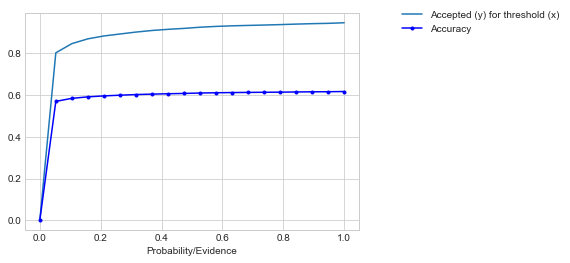

-----------------
      x  y         probs testy
9592  1  1  1.599309e+01     1
9332  9  9  1.240150e+01     1
4278  1  1  1.223094e+01     1
6956  6  6  1.201540e+01     1
7876  1  1  1.171570e+01     1
...  .. ..           ...   ...
4486  8  8  2.445661e-08     1
9292  7  3  1.398935e-08     0
1107  7  7  1.219475e-08     1
6933  0  0  9.812028e-09     1
2892  0  0  4.827367e-09     1

[9984 rows x 4 columns]
rollover enabled, 7454 predictions provided
threshold 0.019689597
max 7.770463943481445


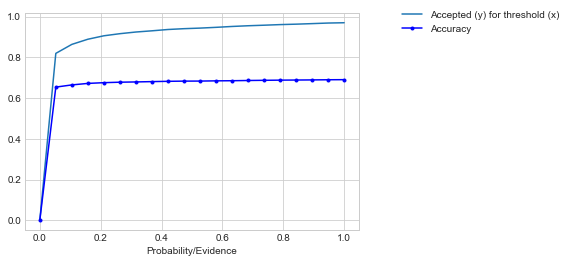

-----------------
      x  y      probs testy
8379  8  8  29.100145     1
8975  8  8  28.888952     1
559   2  2  28.538990     1
2052  8  8  27.878393     1
4455  8  8  27.595686     1
...  .. ..        ...   ...
6500  4  7   0.000008     0
4421  5  2   0.000007     0
6386  5  5   0.000006     1
9794  2  1   0.000006     0
2325  6  7   0.000005     0

[9984 rows x 4 columns]
rollover enabled, 5511 predictions provided
threshold 0.31309432
max 23.523908615112305


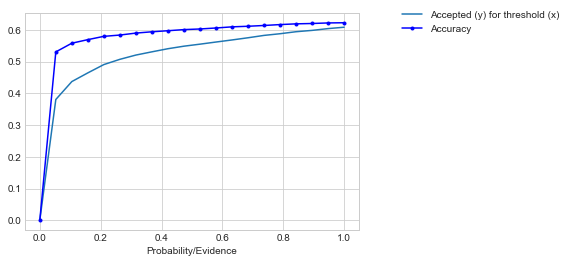

-----------------
      x  y     probs testy
4992  1  1  7.551586     1
3905  2  2  7.551586     1
7560  0  0  7.551586     1
7563  9  9  7.551586     1
3913  7  7  7.551586     1
...  .. ..       ...   ...
5151  1  9  7.461103     0
2325  3  7  7.460432     0
5115  5  5  7.460393     1
3704  7  5  7.459698     0
6543  6  6  7.457842     1

[9984 rows x 4 columns]
rollover enabled, 2866 predictions provided
threshold 0
max 7.551586151123047


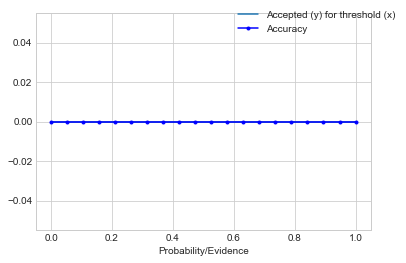

-----------------
thresholds [0.0247632, 0.019689597, 0.31309432, 0]
input_predictions [9984, 7454, 5511, 2866]
Accepted_list [2530, 1943, 2645, 2866]
Acceptance_correct [2223, 1702, 2440, 1704]
overall Accuracy 0.8081931089743589
branch_cost [44131473100, 57162523732, 286229354765, 406546717126]
base cost:  794070068723  total cost: 1125185198592
cost difference:  0.705723884136282


In [28]:
rollOver_indices = pd.Index([])
_predictions = outputs.copy()
    # print(_branch_predictions)
_predictions.append(_predictions.pop(0))
Accepted_df = pd.DataFrame()

Accepted_list =[]
Acceptance_correct =[]
Input_predictions =[]
Branch_cost =[17443270,29419724,108215257,141851611] #flat exit costs
# Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

Base_cost = 112698838
Branch_flops = []
Thresholds=[]

Results=[]
for i, output in enumerate(_predictions):    
    print(output.sort_values(by=['probs'],ascending=False))
    if len(rollOver_indices)>0:
        print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
        output = output.iloc[rollOver_indices]
    # print(output['probs'])
    # print(output)
    from matplotlib import pyplot
    # hist = output.hist(bins=10)
    # print(model.output[i].name)
    mean = output.loc[(output['testy'] == False)].groupby("testy")["probs"].mean().iloc[0]
    std = output.loc[(output['testy'] == False)].groupby("testy")["probs"].std().iloc[0]
    threshold = mean
    # threshold = 0.05
    if i == len(_predictions)-1:
        threshold = 0
    print("threshold", threshold)
    Thresholds.append(threshold)
    Accepted = output.loc[(output["probs"] >= threshold)]
    # print("Accuracy", len(Accepted), Accepted.groupby("testy").count())
    Rejected = output.loc[(output["probs"] < threshold)]
    rollOver_indices = Rejected.index
    # Accepted_df = pd.concat([Accepted_df, Accepted])
    Results.append(Accepted)
    
    Accepted_list.append(len(Accepted))
    Acceptance_correct.append(len(Accepted.loc[(Accepted['testy'] == True)]))
    Input_predictions.append(len(output))
    Branch_flops.append(len(Accepted)* Branch_cost[i]) 
    
    cumulativeClassification(output['testy'].tolist(),output['probs'].tolist(),20)
    print("-----------------")
_Results = pd.concat(Results)
# print(_Results)
# print(_Results.groupby("testy").count())
print("thresholds", Thresholds)
print("input_predictions",Input_predictions)
print("Accepted_list",Accepted_list)
print("Acceptance_correct",Acceptance_correct)
print("overall Accuracy", sum(Acceptance_correct)/sum(Accepted_list))
print("branch_cost", Branch_flops)
print("base cost: ",sum(Branch_flops)," total cost:", sum(Accepted_list)*Base_cost)
print("cost difference: ",sum(Branch_flops)/(sum(Accepted_list)*Base_cost))
